# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Требуется построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Данные находятся в файле autos.csv.  

**Признаки:**  
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак:**
* Price — цена (евро)

# План работ

- Загрузка и ознакомление с данными:
    - загрузка данных
    - проверка данных на пропуски, дубликаты и тип
    - предварительная обработка выявленных аномалий
- Первичный анализ и обработка данных:
    - обзор статистики признаков
    - обзор распределения признаков
    - оценка корреляции численных признаков
    - обработка пропусков и аномалий
    - удаление малоинформативных признаков
    - выделение признаков для обучения модели и целевого признака
    - разделение данных на обучающую и тестовую выборки
    - подготовка признаков: кодирование, масштабирование
- Обучение модели и контроль качества
- Анализ моделей и выбор лучшей
    - определение характеристик моделей, важных заказчику
    - выбор лучшей модели и её проверка на тестовой выборке
    - проверка адекватности модели
- Выводы.

## Загрузка и ознакомление с данными:

In [1]:
# Импортируем необходимые библиотеки и функции
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Создадим функцию для открытия файлов
def open_df (file_name):
    try:
        return pd.read_csv('{}'.format(file_name))
    except:
        print('Не удалось открыть файл "{}"!'.format(file_name))

# Создадим функцию вывода основной информацию о датафрейме
def survey_df(df):
    with pd.option_context('display.max_columns', None):
        print('Размер таблицы: {} строк, {} столбцов'. format(df.shape[0], df.shape[1]))
        display(df.head())
        print('\n', 'Дублирующихся строк:', df.duplicated().sum(), '\n')
        df.info()

# Создадим функцию отображения количества пропусков в датафрейме
def show_pass(df, x, y): # x и y - размер графика
    try:
        (df.isna().mean()*100).to_frame().rename(columns = {0:'space'}).query('space > 0')\
        .sort_values(by = 'space', ascending = True)\
        .plot(kind = 'barh', figsize = (x,y), legend = False, fontsize = 15)\
        .set_title('Количество пропусков в данных в %' + "\n", fontsize = 22, color = 'SteelBlue');
    except:
        print('Пропусков нет!')

In [3]:
# Откроем файл с данными и сохраним его содержимое в переменной data
data = open_df('/datasets/autos.csv')
# И выведем основную информацию о датафрейме
survey_df(data)

Размер таблицы: 354369 строк, 16 столбцов


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



 Дублирующихся строк: 4 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  objec

Данные открыты корректно. Значения в столбцах соответствуют указанным типам данных. В данных есть пропуски и полные дубликаты.

In [4]:
# Проверим дубликаты
data[data.duplicated(keep = False)].sort_values(by = 'Price')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54


In [5]:
# И удалим их
data = data.drop_duplicates(keep='first').reset_index(drop=True)

## Первичный анализ и обработка данных

In [6]:
# Посмотрим на статистики по столбцам
data.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354365,354365.000000,316875,354365.000000,334532,354365.000000,334660,354365.000000,354365.000000,321470,354365,283211,354365,354365.0,354365.000000,354365
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268249,NaN,29232,NaN,NaN,216349,77012,247158,13718,NaN,NaN,17
mean,NaN,4416.679830,NaN,2004.234481,NaN,110.093816,NaN,128211.363989,5.714650,NaN,NaN,NaN,NaN,0.0,50508.503800,NaN
std,NaN,4514.176349,NaN,90.228466,NaN,189.851330,NaN,37905.083858,3.726432,NaN,NaN,NaN,NaN,0.0,25783.100078,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


Минимальное значение в 'Price' и максимальное в 'Power' вызывают подозрениие, посмотрим на их распределения детальнее.

(200.0, 19500.0)

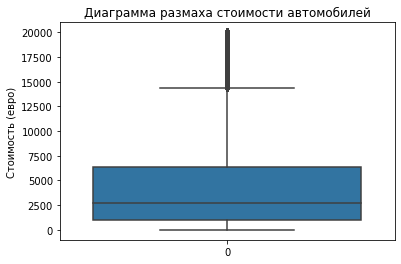

In [7]:
# Посмотим на распределение значений в столбце 'Price'
sns.boxplot(data = data['Price'])
plt.title('Диаграмма размаха стоимости автомобилей')
plt.ylabel('Стоимость (евро)');
np.quantile(data['Price'], 0.05), np.quantile(data['Price'], 0.995)

(5.0, 362.0)

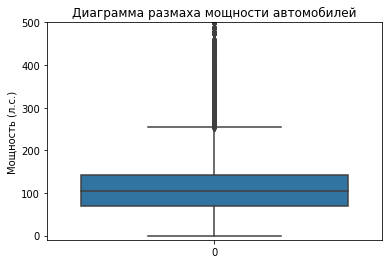

In [8]:
# Посмотим на распределение значений в столбце 'Power'
sns.boxplot(data = data['Power'])
plt.title('Диаграмма размаха мощности автомобилей')
plt.ylabel('Мощность (л.с.)')
plt.ylim([-10, 500]);
np.quantile(data['Power'], 0.114), np.quantile(data['Power'], 0.997)

В статистике по столбцам видны экстремальные и неправдоподобные значения:
- значения года регистрации автомобиля имеют границы от 1000 до 9999; можно попробовать предсказать реальный год выпуска, но необходимо понимать, что некоторые модели могли выпускаться десятилетиями; ограничим выборку диапазоном реального начала выпуска автомобилей 1885 г. и настоящим временем.  
- ничего не стоить автомоболь не может; предсказание стоимости - наша задача, замена неправдоподобно низкой стоимости к.л. значением может навредить модели; ограничим минимальную стоимость 200 евро (5% квантиль); верхнюю границу ограничивать не будем.
- первые модели автомобилей были маломощными, но никак не с 0 л.с., и максимальная мощность в 20 тыс. л.с. то же не вызывает доверия, органичим мощность диапазоном от реального значения первых автомобилей 5..9 л.с. до разумного значения современных - 362 л.с. (99,7% квантиль).

Признаки 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode' и 'LastSeen' врядли оказывают влияние на стоимость, в столбце 'NumberOfPictures' для всех записей указано значение - 0, значит то же не окажет влияния. Избавимся от этих неинформативных признаков.

In [9]:
# Применим принятые ограничения и избавимся от лишних столбцов
data = data[(data['RegistrationYear'] < 2023) & (data['RegistrationYear'] >= 1885) 
            & (data['Price'] > 200) & (data['Power'] > 7) & (data['Power'] < 362)]\
            .drop(['DateCrawled','RegistrationMonth', 'DateCreated', 'NumberOfPictures',
                   'PostalCode', 'LastSeen'], axis=1).reset_index(drop=True)

In [10]:
# Проверим результат
data.describe(include='all')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
count,300676.000000,280430,300676.000000,294984,300676.000000,288916,300676.000000,282017,300676,255706
unique,NaN,8,NaN,2,NaN,249,NaN,7,40,2
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no
freq,NaN,81932,NaN,235631,NaN,25527,NaN,187282,65734,228141
mean,4876.426087,NaN,2003.379694,NaN,120.304128,NaN,128345.411672,NaN,NaN,NaN
std,4566.855167,NaN,6.919165,NaN,51.771457,NaN,36669.879399,NaN,NaN,NaN
min,202.000000,NaN,1910.000000,NaN,8.000000,NaN,5000.000000,NaN,NaN,NaN
25%,1400.000000,NaN,1999.000000,NaN,77.000000,NaN,125000.000000,NaN,NaN,NaN
50%,3200.000000,NaN,2003.000000,NaN,111.000000,NaN,150000.000000,NaN,NaN,NaN
75%,6990.000000,NaN,2008.000000,NaN,150.000000,NaN,150000.000000,NaN,NaN,NaN


In [11]:
data.shape

(300676, 10)

Неинформативные признаки удалены корректно.  
Значения в количественных признаках теперь выглядят более правдоподобно.  
Потери составили порядка 15.15% - это достаточно много, но так данные стали более репрезентативны.

Обработаем пропуски.

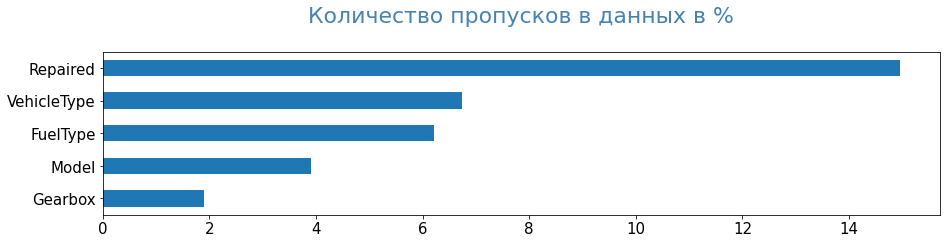

In [12]:
# Посмотрим на пропуски
show_pass(data, 15, 3)

Пропуски обнаружены в категориальных признаках: Repaired, VehicleType, FuelType, Model, Gearbox. Repaired (больше всего пропусков, более 15%) могли не заполнить чтобы не показывать факт ремонта автомобиля, из-за незнания этого факта, или посчитали что если ремонта не было - то и указывать не обязательно. Остальные признакимогли оказаться не заполенными из-за незнания, невнимательности, или посчитав эти признаки незначительными. Количество пропусков значительное - удалять не стоит, особенно с учётом уже отсеянных 15,15% данных.

Посмотрим на уникальные значения в этих столбцах.

In [13]:
# Уникальные значений в 'Repaired' и 'Gearbox'
data['Repaired'].unique(), data['Gearbox'].unique()

(array(['yes', nan, 'no'], dtype=object),
 array(['manual', 'auto', nan], dtype=object))

In [14]:
# Уникальные значения в 'VehicleType'
data['VehicleType'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       nan, 'other'], dtype=object)

In [15]:
# Уникальные значения в 'FuelType'
data['FuelType'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [16]:
# Уникальные значения в 'Model'
data['Model'].unique()

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'other', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'one',
       'fortwo', '1er', 'b_klasse', 'a8', 'jetta', 'astra', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'ka', 'a1', 'focus', 'a4', 'tt',
       'a6', 'jazz', 'omega', 'slk', '7er', 'combo', 'corsa', '80', '147',
       'z_reihe', 'sportage', 'sorento', 'ibiza', 'mustang', 'eos',
       'touran', 'getz', 'insignia', 'almera', 'megane', 'a3', 'lupo',
       'r19', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza', 'vectra',
       'berlingo', 'tiguan', 'i_reihe', '6_reihe', 'panda', 'up', 'ceed',
       'kangoo', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'rio',
       'touareg', 'logan', '

Заполним пропуски в Repaired и Gearbox "заглушкой" - 'undefined'. В VehicleType, FuelType и Model встерчается 'other' - заполним пропуски этим значением.

In [17]:
# Заполним пропуски
data[['Repaired', 'Gearbox']] = data[['Repaired', 'Gearbox']].fillna('undefined')
data[['VehicleType', 'FuelType', 'Model']] = data[['VehicleType', 'FuelType', 'Model']].fillna('other')

In [18]:
# Проверим результат
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300676 entries, 0 to 300675
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             300676 non-null  int64 
 1   VehicleType       300676 non-null  object
 2   RegistrationYear  300676 non-null  int64 
 3   Gearbox           300676 non-null  object
 4   Power             300676 non-null  int64 
 5   Model             300676 non-null  object
 6   Kilometer         300676 non-null  int64 
 7   FuelType          300676 non-null  object
 8   Brand             300676 non-null  object
 9   Repaired          300676 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.9+ MB


Пропусков в данных больше нет.

Посмотрим на распределение и взаимосвязь численных признаков.

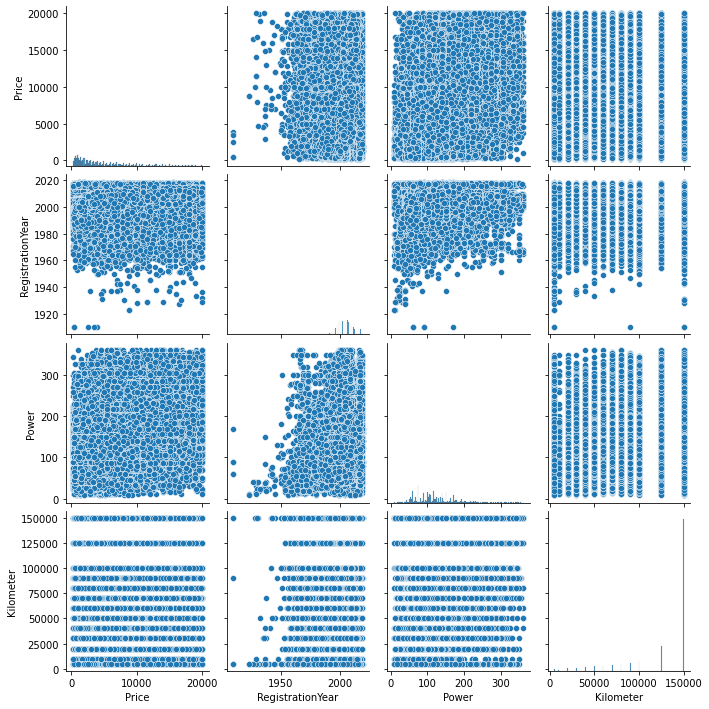

In [19]:
# Построимт попрарный график распределения численных признаков
sns.pairplot(data);

Сильных взаимосвязей в численных принаках нет. Можно увидеть - основная масса автомобилей зарегистрирована после 1950 года, пик пришелся на начало 2000-х годов, имеет мощность в диапазоне от 50 до 200 л.с., с пробегом более 100 тыс.км.

Разделим данные на обучающую и тестовую выборки.

In [20]:
# Отделим признаки от целевых признаков
features = data.drop(['Price'], axis=1)
target = data['Price']

# Разделим признаки на обучающу и тестовую выборки в соотношении 3:1
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [21]:
# Проверим разделение
features_train.shape, features_test.shape

((225507, 9), (75169, 9))

Разделение прошло корректно.

Признак 'Model' имеет большое количество значений, проверим все ли значения есть в обучающей и тестовой выборках.

In [22]:
# Выберем уникальные значения признака 'Model' в обучающей и тестовой выборках
models_train = set(features_train['Model'].unique())
models_test = set(features_test['Model'].unique())
# Определим количество уникальных значений признака 'Model' в обучающей и тестовой выборках
num_models_train = len(models_train)
num_models_test = len(models_test)
# Определим есть ли различия, и какие
print('Количество уникальных значений признка "Model" в обеих выборках одинаковое:',
      num_models_train == num_models_test)
print('Уникальные значения признка "Model" в обеих выборках одинаковые:',
      models_train == models_test)
print('Только в обучающей выборке есть значения:', (models_train - models_test))
print('Только в тестовой выборке есть значения:', (models_test - models_train))

Количество уникальных значений признка "Model" в обеих выборках одинаковое: False
Уникальные значения признка "Model" в обеих выборках одинаковые: False
Только в обучающей выборке есть значения: {'serie_3'}
Только в тестовой выборке есть значения: set()


Модели автомобилей распределились по выборкам неравномерно: в тестовой выборке есть все модели из отбучающей, в обучающей есть модель 'serie_3', которой нет в тестовой. Для предказаний это не будет проблемой. На случай обратной ситуации, когда в обучающей выборке есть не все варианты, укажем кодировщику категориальных признаков как это обрабатывать. 

Подготовим признаки для моделей.

In [23]:
# Создадим список категориальных признаков
cat_features = features_train.select_dtypes(include='object').columns.to_list()
cat_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [24]:
# Создадим список численных признаков
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features

['RegistrationYear', 'Power', 'Kilometer']

In [25]:
# Произведём масштабирование численных признаков
scaler = StandardScaler()
features_train[num_features] = scaler.fit_transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

In [26]:
# Подготовим признаки для модели LightGBM_Regressor
features_train_lgbm = features_train.copy()
features_test_lgbm = features_test.copy()
features_train_lgbm[cat_features] = features_train_lgbm[cat_features].astype('category')
features_test_lgbm[cat_features] = features_test_lgbm[cat_features].astype('category')

In [27]:
# Проверим преобразование типов
features_train_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225507 entries, 55106 to 217570
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       225507 non-null  category
 1   RegistrationYear  225507 non-null  float64 
 2   Gearbox           225507 non-null  category
 3   Power             225507 non-null  float64 
 4   Model             225507 non-null  category
 5   Kilometer         225507 non-null  float64 
 6   FuelType          225507 non-null  category
 7   Brand             225507 non-null  category
 8   Repaired          225507 non-null  category
dtypes: category(6), float64(3)
memory usage: 8.4 MB


In [28]:
# Подготовим признаки для моделей, не умеющих работать с категориальными данными
features_train_oth = features_train.copy()
features_test_oth = features_test.copy()
# Использование линейной регрессии не планируется, применим порядковое кодирование
# Добавим в кодировщик параметры для обработки ранее не встречавшихся значений - 
# будем присваивать им порядковый номер '-1'
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
features_train_oth[cat_features] = encoder.fit_transform(features_train_oth[cat_features])
features_test_oth[cat_features] = encoder.transform(features_test_oth[cat_features])

In [29]:
# Проверим результат кодирования
features_test_oth.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
121059,0.0,0.235526,1.0,-0.449257,248.0,-0.091914,0.0,24.0,0.0
217820,0.0,0.957312,1.0,-0.197960,248.0,-0.091914,2.0,24.0,0.0
187205,4.0,-0.197546,0.0,0.575259,11.0,0.590079,2.0,2.0,0.0
128896,5.0,0.957312,1.0,-1.067832,151.0,-2.410689,6.0,23.0,0.0
209049,5.0,0.091168,1.0,-0.913188,132.0,0.590079,6.0,7.0,1.0


Данные подготовлены, можно переходить к обучению моделей.

В нашем исследовании проверим две модели: LightgbmGBM Regressor и RandomForest Regressor, а так же сравним результат с константной моделью DummyRegressor.

## Обучение модели и контроль качества:

Произведём подбор гиперпараметров для LightGBM Regressor

In [30]:
%%time
param_grid_lgbm = {'max_depth': range(10, 12), 'n_estimators': range(100, 111, 10)}
search_lgbm_r = GridSearchCV(LGBMRegressor(random_state=12345, n_jobs=-1), 
                             param_grid=param_grid_lgbm, cv=5, refit=True, 
                             scoring='neg_root_mean_squared_error', n_jobs=-1)
search_lgbm_r.fit(features_train_lgbm, target_train)

print(' Лучшее значение RMSE:', round(-search_lgbm_r.best_score_, 2),
      '\n При значениях гиперпараметров:', search_lgbm_r.best_params_)

 Лучшее значение RMSE: 1615.39 
 При значениях гиперпараметров: {'max_depth': 11, 'n_estimators': 110}
CPU times: user 2min 23s, sys: 1.15 s, total: 2min 24s
Wall time: 2min 26s


Произведём подбор гиперпараметров для RandomForest Regressor

In [31]:
%%time
param_grid_rf = {'max_depth': range(14, 16), 'n_estimators': range(200, 251, 50)}
search_rf_r = GridSearchCV(RandomForestRegressor(random_state=12345, n_jobs=-1), 
                      param_grid=param_grid_rf, cv=5, refit=True, 
                      scoring='neg_root_mean_squared_error', n_jobs=-1)
search_rf_r.fit(features_train_oth, target_train)

print(' Лучшее значение RMSE:', round(-search_rf_r.best_score_, 2),
      '\n При значениях гиперпараметров:', search_rf_r.best_params_)

 Лучшее значение RMSE: 1624.19 
 При значениях гиперпараметров: {'max_depth': 15, 'n_estimators': 250}
CPU times: user 29min 50s, sys: 4.04 s, total: 29min 54s
Wall time: 29min 55s


В процессе подбора гиперпатаметров получили следующий результат:
- для модели LightGBM Regressor метрика RMSE составила 1615.39 при значениях гиперпараметров 'max_depth'=11, 'n_estimators'=110.
- для модели RandomForest Regressor метрика RMSE составила 1624.19 при значениях гиперпараметров 'max_depth'=15, 'n_estimators'=250.

Значения метрики RMSE для обеих моделей на обучающей выборке соответствуют критерию заказчика (менее 2500) и незначительно отличаются между собой. Проанализируем другие важные для заказчика критерии.

## Анализ моделей

Для оценки моделей и выбора лучшей для нашей задачи извлечём из атрибута cv_results_  значения времени обучения ('mean_fit_time') и предсказания ('mean_score_time') для search_lgbm_r и search_rf_r с лучшими найденными параметрами. Сведём значения в таблицу и добавим значения RMSE для них.

In [32]:
grid_res_lgbm = pd.DataFrame(search_lgbm_r.cv_results_).\
                sort_values(by='rank_test_score').reset_index(drop=True)
grid_res_rf = pd.DataFrame(search_rf_r.cv_results_).\
                sort_values(by='rank_test_score').reset_index(drop=True)
pd.DataFrame({'Качество предсказания (RMSE)' : [round(-search_lgbm_r.best_score_, 2), 
                                                round(-search_rf_r.best_score_, 2)], 
              'Время обучения, сек.' : [round(grid_res_lgbm.loc[0]['mean_fit_time'], 2), 
                                        round(grid_res_rf.loc[0]['mean_fit_time'], 2)], 
              'Время предсказания, сек.' : [round(grid_res_lgbm.loc[0]['mean_score_time'], 2),
                                            round(grid_res_rf.loc[0]['mean_score_time'], 2)]}, 
             index=['LightGBM Regressor', 'RandomForest Regressor'])

,Качество предсказания (RMSE),"Время обучения, сек.","Время предсказания, сек."
LightGBM Regressor,1615.39,6.02,0.58
RandomForest Regressor,1624.19,89.73,2.27


На основании важных для заказчика критериев для задачи предсказания стоимости автомобиля можно рекомендовать модель LightgbmGBM Regressor: более точная (хотя и незначительно), значительно быстрее обучается и быстрее предсказывает.

Посмотрим на качество предсказания рекомендованной модели на тестовой выборке.

In [33]:
print('Значение RMSE модели LightGBM Regressor для тестовой выборки: ',
      round(mean_squared_error(target_test, 
                               search_lgbm_r.predict(features_test_lgbm), 
                               squared=False), 
            2))

Значение RMSE модели LightGBM Regressor для тестовой выборки:  1624.21


Дополнительно сравним результаты с константной моделью

In [34]:
%%time
# Посмотрим на время обучения модели DummyRegressor
model_dr = DummyRegressor(strategy="median") 
model_dr.fit(features_train_oth, target_train)

CPU times: user 5.06 ms, sys: 3 µs, total: 5.06 ms
Wall time: 3.8 ms


DummyRegressor(strategy='median')

In [35]:
%%time
# Посмотрим на время предсказания модели DummyRegressor
# и вычислим RMSE на обучающей выборке
predict_dr = model_dr.predict(features_test_oth)
print('Значение RMSE константной модели DummyRegressor для тестовой выборки: ',
      round(mean_squared_error(target_test, predict_dr, squared=False), 2))

Значение RMSE константной модели DummyRegressor для тестовой выборки:  4897.73
CPU times: user 2.19 ms, sys: 7 µs, total: 2.19 ms
Wall time: 1.66 ms


Константная модель DummyRegresso самая быстрая и самая неточная: время обучения 3.57 ms, предсказания - 1.33 ms, но RMSE значительно выше требований заказчика - 4897.73.

По результатам анализа моделей, лучше всего критериям заказчика соответсвует модель LightGBM Regressor:
- качество предсказания не уступает модели RandomForest Regressor
- время обучения значительно меньше чем у RandomForest Regressor
- время предсказания так же значительно меньше чем у RandomForest Regressor

## Выводы:
- Исходные данные содержали 354369 записей по 16 признаков; в данных были обнаружены дубликаты и пропуски, а так же аномальные и неправдоподобные значения; в результате подготовки данных было потеряно 15,15% записей, были отброшены 6 неинформативных признаков, а так же заполнены пропуски в категориальных признаках.
- В процессе обучения моделей было обнаружено, что скорость обучения LightGBM Regressor значительно выше таковой у RandomForest Regressor при сопоставимой точности предсказаний.
- В результате анализа моделей подтвердилась более высокая скорость обучения LightGBM Regressor, а так же более высокая скорость предсказания этой модели, при сопоставимой с RandomForest Regressor точности предсказаний.
- Параметры лучшей модели LightGBM Regressor: 'max_depth': 11, 'n_estimators': 110. Значение RMSE для тестовой выборки:  1624.21

Опираясь на критерии заказчика, для задачи определения стоимости автомобилей выбираем модель LightGBM Regressor